In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
import scipy
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/home/ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,age,"Gender(male=0,female=1)",Disease duration(years),LEDD
1,1.0,62.26%,NaN,53,20,40,15,7,66,1,9,825
2,2.0,75.00%,NaN,32,8,26,17,10,64,1,6,856.25
3,3.0,51.72%,NaN,58,28,52,18,20,67,1,15,1350
4,4.0,22.58%,NaN,62,48,61,36,28,69,1,5,350
5,5.0,55.88%,NaN,34,15,44,29,22,63,1,10,751.25
6,6.0,75.44%,NaN,57,14,55,32,16,67,1,5,525
7,7.0,84.00%,NaN,100,16,68,12,NaN,58,0,10,1087.5
8,8.0,41.86%,NaN,43,25,48,26,26,74,1,10,550
9,9.0,72.58%,NaN,62,17,56,25,11,57,1,10,500


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
age = np.nan_to_num(np.asarray(df[df.columns[-4]])[1:][np.in1d(subject_id,case_number)].astype(float))
sex = np.nan_to_num(np.asarray(df[df.columns[-3]])[1:][np.in1d(subject_id,case_number)].astype(float))
dd = np.nan_to_num(np.asarray(df[df.columns[-2]])[1:][np.in1d(subject_id,case_number)].astype(float))
ledd = np.nan_to_num(np.asarray(df[df.columns[-1]])[1:][np.in1d(subject_id,case_number)].astype(float))

for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.repeat(R[1:5],n_features-1)
K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
K_all_c = np.append(K_all_c,['pre updrs']*5)
R_all_c = np.append(R_all_c,['pre updrs']*5)
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
# K_all_c = np.append(K_all_c,['ledd'])
# R_all_c = np.append(R_all_c,['ledd'])

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
retrain = 1

In [36]:
# Noise compensated LASSO
K_nz_nc = []
K_nz_nc_lr = []
E_nz_nc = []
E_nz_nc_lr = []
#R_nz_cd = []
if retrain == 1:

  aug = True
  K_nz = []
  c = 0

  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train0 = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train0 <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,
                                                  None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train0)
      kappa = stats.skew(y_train0)
      print('Label distribution of:',mu,sigma,kappa)
      Q = 4
      for jj in np.arange(Q):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
          y_train0 = np.append(y_train0,y_train0[idyr])
          y_cat = y_train0 <= 0.3
          rs = rs+1
          print('Resampled to size',y_train0.shape)
          y_train_n = y_train0
          X0_ss0_n = X0_ss00
        if aug == True:
          y_train_n = np.append(y_train_n,y_train0+(1.96*sigma)*np.random.normal(0,1,1))
          y_cat = y_train_n <= 0.3
          X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)

      y_train = y_train_n
      X0_ss0 = X0_ss0_n
      
      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=10000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        # lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=-1)
          # Stratifies classifiers automatically
          # sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=-1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
        #   est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
        #   cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        # best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          # cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
            #   X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
            #   est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=10000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            #   lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=1)
              est_ls = lasso.fit(X0_ss,y_train)
            #   est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              # cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
        #   best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        #lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        # K_ss_lr = sel_lr.transform(K_all_c.reshape(1,-1))
        # R_ss = sel.transform(R_all_c.reshape(1,-1))


      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
    #    lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        est_ls = lasso.fit(X0_ss,y_train)
    #     est_lgr = lgr.fit(X0_ssl,y_cat)
    #   results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
    #   results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      K_nz_nc.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      E_nz_nc.append(est_ls.coef_[abs(est_ls.coef_)>0])
    #   K_nz_nc_lr.append(np.squeeze(K_ss_lr)[np.squeeze(abs(est_lgr.coef_)>0)])
    #   E_nz_nc_lr.append(est_lgr.coef_[abs(est_lgr.coef_)>0])
      c=c+1

  np.save('results_ls_aug_d_cvs.npy',results_ls_aug)
#   np.save('results_lgr_aug_d_cvs.npy',results_lgr_aug)
#   np.save('results_lgrp_aug_d_cvs.npy',results_lgrp_aug)
  np.save('results_K_nz_nc_cvs_all.npy',K_nz_nc)
  np.save('results_K_nz_nc_lr_cvs.npy',K_nz_nc_lr)
  np.save('beta_nz_nc_cvs.npy',E_nz_nc)
  np.save('beta_nz_nc_lr_cvs.npy',E_nz_nc_lr)
else:
  results_ls_aug = np.load('results_ls_aug_d_cvs.npy')
  results_lgr_aug = np.load('results_lgr_aug_d_cvs.npy')
  results_lgrp_aug = np.load('results_lgrp_aug_d_cvs.npy')
  K_nz_nc = np.load('results_K_nz_nc_cvs_all.npy',allow_pickle=True)

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.52120001] from dataset of size (190, 1388)
LassoCV score for 3 is [0.52409504] from dataset of size (190, 6388)
LassoCV score for 4 is [0.52051234] from dataset of size (190, 1388)
LassoCV score for 5 is [0.53319246] from dataset of size (190, 3388)
Lasso predicts 0.6772 and logistic regression predicts 0.0 for case with 0.72 and selected CV 5 and 53 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.52933867] from dataset of size (190, 6388)
LassoCV score for 3 is [0.52623221] from dataset of size (190, 1388)
LassoCV score for 4 is [0.51883312] from dataset of size (190, 5388)
LassoCV score for 5 is [0.53434358] from dataset of size (190, 5388)
Lasso predicts 0.4343 and logistic regression predicts 0.0 for case w

: 

In [30]:
# Noise compensated LASSO
K_nz_nc = []
K_nz_nc_lr = []
E_nz_nc = []
E_nz_nc_lr = []
#R_nz_cd = []
if retrain == 1:

  aug = True
  K_nz = []
  c = 0

  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train0 = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train0 <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,
                                                  None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train0)
      kappa = stats.skew(y_train0)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
          y_train0 = np.append(y_train0,y_train0[idyr])
          y_cat = y_train0 <= 0.3
          rs = rs+1
          print('Resampled to size',y_train0.shape)
          y_train_n = y_train0
          X0_ss0_n = X0_ss00
        if aug == True:
          print('Size before appending',y_train_n.shape)
          y_train_n = np.append(y_train_n,y_train0+(2.326*sigma)*np.random.normal(0,1,1))
          print('Size after appending',y_train_n.shape)
          y_cat = y_train_n <= 0.3
          X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)

      y_train = y_train_n
      X0_ss0 = X0_ss0_n
      print(y_train_n.shape)
      print(X0_ss0.shape)
      
      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=10000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=-1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=-1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=10000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=1)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        K_ss_lr = sel_lr.transform(K_all_c.reshape(1,-1))
        # R_ss = sel.transform(R_all_c.reshape(1,-1))


      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
      results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
      results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv_lgr,'and',sum(y_cat),'minority cases')
      K_nz_nc.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      E_nz_nc.append(est_ls.coef_[abs(est_ls.coef_)>0])
      K_nz_nc_lr.append(np.squeeze(K_ss_lr)[np.squeeze(abs(est_lgr.coef_)>0)])
      E_nz_nc_lr.append(est_lgr.coef_[abs(est_lgr.coef_)>0])
      c=c+1

  np.save('results_ls_aug_d_cvs.npy',results_ls_aug)
  np.save('results_lgr_aug_d_cvs.npy',results_lgr_aug)
  np.save('results_lgrp_aug_d_cvs.npy',results_lgrp_aug)
  np.save('results_K_nz_nc_cvs_all.npy',K_nz_nc)
  np.save('results_K_nz_nc_lr_cvs.npy',K_nz_nc_lr)
  np.save('beta_nz_nc_cvs.npy',E_nz_nc)
  np.save('beta_nz_nc_lr_cvs.npy',E_nz_nc_lr)
else:
  results_ls_aug = np.load('results_ls_aug_d_cvs.npy')
  results_lgr_aug = np.load('results_lgr_aug_d_cvs.npy')
  results_lgrp_aug = np.load('results_lgrp_aug_d_cvs.npy')
  K_nz_nc = np.load('results_K_nz_nc_cvs_all.npy',allow_pickle=True)

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
Size before appending (38,)
Size after appending (76,)
Size before appending (76,)
Size after appending (114,)
Size before appending (114,)
Size after appending (152,)
(152,)
(152, 6388)
LassoCV score for 2 is [0.417601] from dataset of size (152, 388)
LassoCV score for 3 is [0.40980113] from dataset of size (152, 5388)
LassoCV score for 4 is [0.12005114] from dataset of size (152, 1)
LassoCV score for 5 is [0.39024093] from dataset of size (152, 5388)
Lasso predicts 0.6337 and logistic regression predicts 0.0 for case with 0.72 and selected CV 4 and 41 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
Size before appending (38,)
Size after appending (76,)
Size before appending (76,)
Size after appending (114,)
Size before appending (114,)
Size after appending (15

In [12]:
retrain = 1

In [13]:
# Vanilla Lasso
if retrain == 1:
  Js = []
  aug = False
  K_nz_vl = []
  K_nz_vl_lr = []
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz_vl = []
  E_nz_vl_lr = []
  c = 0

  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
        else:
          y_train_n = y_train
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
          
      
      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          warnings.filterwarnings("ignore", category=UserWarning)
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
          print('Found minority samples:',sum(y_cat))
          # Feature selection
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LogisticRegressionCV score for',jj,'is',cv_lgr_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=1)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        K_ss_lr = sel_lr.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
      results_lgr[c] = est_lgr.predict(X_test_ssl)
      results_lgrp[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls[c],4)),'and logistic regression predicts',results_lgr[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv_lgr,'and',sum(y_cat),'minority cases')
      K_nz_vl.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      E_nz_vl.append(est_ls.coef_[abs(est_ls.coef_)>0])
      K_nz_vl_lr.append(np.squeeze(K_ss_lr)[np.squeeze((est_lgr.coef_)>0)])
      E_nz_vl_lr.append(est_lgr.coef_[abs(est_lgr.coef_)>0])
      c=c+1

  np.save('results_ls_d_cvs.npy',results_ls)
  np.save('results_lgr_d_cvs.npy',results_lgr)
  np.save('results_lgrp_d_cvs.npy',results_lgrp)
  np.save('results_K_nz_vl_cvs_all.npy',K_nz_vl)
  np.save('results_K_nz_vl_lr_cvs.npy',K_nz_vl_lr)
  np.save('beta_nz_vl_cvs.npy',E_nz_vl)
  np.save('beta_nz_vl_lr_cvs.npy',E_nz_vl_lr)

    
else:
  results_ls = np.load('results_ls_d_cvs.npy')
  results_lgr = np.load('results_lgr_d_cvs.npy')
  results_lgrp = np.load('results_lgrp_d_cvs.npy')
  K_nz_vl = np.load('results_K_nz_vl_cvs_all.npy',allow_pickle=True)

Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
Found minority samples: 40
LogisticRegressionCV score for 2 is [1.] from dataset of size (304, 4388)
Found minority samples: 40
LogisticRegressionCV score for 3 is [1.] from dataset of size (304, 5388)
Found minority samples: 40
LogisticRegressionCV score for 4 is [1.] from dataset of size (304, 1388)
Found minority samples: 40
LogisticRegressionCV score for 5 is [1.] from dataset of size (304, 1388)
Lasso predicts 0.6615 and logistic regression predicts 0.0 for case with 0.72 and selected CV 2 and 40 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
Found minority samples: 40
LogisticRegressionCV score for 2 is [1.] from dataset of size (304, 1388)
Found minority samples: 40
LogisticRegressionCV score for 3 is [1.] from dataset of size (304, 1388)
Found minority 

In [14]:
# Vanilla Lasso
results_lsw = np.zeros_like(per_change)
results_lgrw = np.zeros_like(per_change)
results_lgrwp = np.zeros_like(per_change)

if retrain == 1:
  Js = []
  aug = False
  K_nz_vlw = []
  K_nz_vlw_lr = []
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nzw = []
  E_nz_vlw = []
  E_nz_vlw_lr = []
  c = 0

  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)

      # Cross validation
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)

           # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
          
      for jj in np.arange(2,cvn+1):

        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          warnings.filterwarnings("ignore", category=UserWarning)
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=0)
          print('Found minority samples:',sum(y_cat))
          # Feature selection
          sel = skf.RFECV(lasso,step=rcfs,cv=jj,n_jobs=1)
          # Stratifies classifiers automatically
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('Lasso score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None,penalty='l1',solver='liblinear',random_state=1)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))


      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
  
      results_lsw[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_lsw[c],4)),'and logistic regression predicts',results_lgrw[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      try:
        K_nz_vlw.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      except:
        K_nz_vlw.append(K_ss[abs(est_ls.coef_)>0])
      c=c+1

  np.save('results_lsw_d_cvs.npy',results_lsw)
  np.save('results_K_nz_vlw_cvs_all.npy',K_nz_vlw)

    
else:
  results_lsw = np.load('results_lsw_d_cvs.npy')
  K_nz_vlw = np.load('results_K_nz_vlw_cvs_all.npy',allow_pickle=True)

Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
Found minority samples: 5
Lasso score for 2 is [0.99433434] from dataset of size (38, 5388)
Found minority samples: 5
Lasso score for 3 is [0.96952941] from dataset of size (38, 6388)
Found minority samples: 5
Lasso score for 4 is [0.99926543] from dataset of size (38, 388)
Found minority samples: 5
Lasso score for 5 is [0.99999893] from dataset of size (38, 388)
Lasso predicts 0.685 and logistic regression predicts 0.0 for case with 0.72 and selected CV 5 and 5 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
Found minority samples: 5
Lasso score for 2 is [0.84160638] from dataset of size (38, 2388)
Found minority samples: 5
Lasso score for 3 is [0.99891625] from dataset of size (38, 4388)
Found minority samples: 5
Lasso score for 4 is [0.99999997] from dataset 

In [15]:
# SMOGN LASSO
if retrain == 1:
  results_ls_smogn = np.zeros_like(per_change)
  aug = False
  c = 0
  K_nz_smogn = []
  #R_nz_smogn = []
  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      X_smogn,y_smogn,idx_kept,sscaler = util.rad_smogn(X0_ss0,y_train,np.amax(y_train),np.amin(y_train),1,0,0.05,0.02,1)
      X0_ss00 = X0_ss0
      X0_ss0 = np.vstack((X0_ss0,X_smogn))
      y_train = np.hstack((y_train,y_smogn))
      y_train_0 = y_train
      cvn = 5

      cv_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)

      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
          X0_sst = sel.fit_transform(X0_ss0,y_train)
          X0_ss = X0_sst
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          for jjj in (cv_scores == cv_scores(best_cv)):
            if jjj > 0:
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_sst = sel.fit_transform(X0_ss0,y_train)
              X0_ss = X0_sst
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              est_ls = lasso.fit(X0_ss,y_train)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
          best_cv = np.argmax(cv_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        
      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
        results_ls_smogn[c] = est_ls.predict(X_test_ss)
        if results_ls_smogn[c] < 0:
            dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
            results_ls_smogn[c] = np.mean((y_train_0[y_n]))
            print('Using nearest neighbor')
        print('Lasso predicts',str(np.round(results_ls_smogn[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
      try:
        K_nz_smogn.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      except:
        next
      #   K_nz_smogn.append(K_ss[abs(est_ls.coef_)>0])
      c=c+1


  np.save('results_ls_smogn_d_cvs.npy',results_ls_smogn)
  np.save('results_K_nz_smogn_cvs_all.npy',K_nz_smogn)
  np.save('beta_nz_smogn_cvs.npy',est_ls.coef_[abs(est_ls.coef_)>0])

else:
  results_ls_smogn = np.load('results_ls_smogn_d_cvs.npy')
  K_nz_smogn = np.load('results_K_nz_smogn_cvs_all.npy',allow_pickle=True)
  


Prior to SMOGN sampling, mean is 2.2541551794212183e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.18it/s]


Label distribution of: 0.5195628882490358 0.21722529948915376 0.1525270395912942
Resampled to size (57,)
LassoCV score for 2 is [0.99999019] from dataset of size (57, 6388)
LassoCV score for 3 is [0.99964949] from dataset of size (57, 3388)
LassoCV score for 4 is [1.] from dataset of size (57, 6388)
LassoCV score for 5 is [1.] from dataset of size (57, 1388)
Lasso predicts 0.6223 for case with 0.72 and selected CV 4
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.5176245053469528 0.21659792338103973 0.12198074191989151
Resampled to size (59,)
LassoCV score for 2 is [0.99989213] from dataset of size (59, 388)
LassoCV score for 3 is [0.99989503] from dataset of size (59, 5388)
LassoCV score for 4 is [1.] from dataset of size (59, 2388)
LassoCV score for 5 is [0.99999385] from dataset of size (59, 6388)
Lasso predicts 0.5048 for case with 0.47 and selected CV 4
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.18it/s]


Label distribution of: 0.520050851814423 0.21763713924159928 0.14974032674928353
Resampled to size (57,)
LassoCV score for 2 is [0.99832566] from dataset of size (57, 4388)
LassoCV score for 3 is [0.99951815] from dataset of size (57, 6388)
LassoCV score for 4 is [0.99783192] from dataset of size (57, 2388)
LassoCV score for 5 is [0.99874563] from dataset of size (57, 1388)
Lasso predicts 0.807 for case with 0.69 and selected CV 3
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.16it/s]


Label distribution of: 0.5204390236596631 0.21654678794406318 0.08086488810575351
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 1388)
LassoCV score for 3 is [0.99994602] from dataset of size (59, 388)
LassoCV score for 4 is [1.] from dataset of size (59, 6388)
LassoCV score for 5 is [0.99997952] from dataset of size (59, 2388)
Lasso predicts 0.5483 for case with 0.42 and selected CV 2
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.5305893865575467 0.20366725488006449 0.1815835854395165
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 3388)
LassoCV score for 3 is [1.] from dataset of size (59, 2388)
LassoCV score for 4 is [1.] from dataset of size (59, 388)
LassoCV score for 5 is [1.] from dataset of size (59, 388)
Lasso predicts 0.4642 for case with 0.15 and selected CV 2
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.03s/it]


Label distribution of: 0.518664035845111 0.2162881691225332 0.10937392534199468
Resampled to size (59,)
LassoCV score for 2 is [0.99999974] from dataset of size (59, 1388)
LassoCV score for 3 is [0.99727738] from dataset of size (59, 6388)
LassoCV score for 4 is [0.99999704] from dataset of size (59, 388)
LassoCV score for 5 is [1.] from dataset of size (59, 1388)
Lasso predicts 0.4879 for case with 0.44 and selected CV 5
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5157576745465406 0.2122210657421621 0.12129929136333849
Resampled to size (57,)
LassoCV score for 2 is [0.99779311] from dataset of size (57, 3388)
LassoCV score for 3 is [1.] from dataset of size (57, 1388)
LassoCV score for 4 is [0.99998209] from dataset of size (57, 2388)
LassoCV score for 5 is [0.99999685] from dataset of size (57, 4388)
Lasso predicts 0.7711 for case with 0.88 and selected CV 3
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5204876289082958 0.2153989754748039 0.09138535470117073
Resampled to size (59,)
LassoCV score for 2 is [0.99990712] from dataset of size (59, 5388)
LassoCV score for 3 is [0.99844165] from dataset of size (59, 3388)
LassoCV score for 4 is [0.9971072] from dataset of size (59, 5388)
LassoCV score for 5 is [0.99999581] from dataset of size (59, 4388)
Lasso predicts 0.5907 for case with 0.4 and selected CV 5
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.5217094407227338 0.21856744906013956 0.13264204668369198
Resampled to size (57,)
LassoCV score for 2 is [0.98649909] from dataset of size (57, 4388)
LassoCV score for 3 is [0.9918085] from dataset of size (57, 1388)
LassoCV score for 4 is [0.99926129] from dataset of size (57, 1388)
LassoCV score for 5 is [0.99999955] from dataset of size (57, 1388)
Lasso predicts 0.5986 for case with 0.6 and selected CV 5
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Label distribution of: 0.5173350554989217 0.21461723160341947 0.14598134716711256
Resampled to size (57,)
LassoCV score for 2 is [0.9999751] from dataset of size (57, 388)
LassoCV score for 3 is [0.99990179] from dataset of size (57, 6388)
LassoCV score for 4 is [0.99992475] from dataset of size (57, 388)
LassoCV score for 5 is [0.99992591] from dataset of size (57, 5388)
Lasso predicts 0.5396 for case with 0.81 and selected CV 2
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.5209679464585902 0.21824085373262123 0.14143537158889227
Resampled to size (57,)
LassoCV score for 2 is [0.99631126] from dataset of size (57, 4388)
LassoCV score for 3 is [0.99995929] from dataset of size (57, 4388)
LassoCV score for 4 is [1.] from dataset of size (57, 388)
LassoCV score for 5 is [0.99999999] from dataset of size (57, 1388)
Lasso predicts 0.8072 for case with 0.64 and selected CV 4
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.25s/it]


Label distribution of: 0.5195729457781021 0.2172344264886018 0.15248330423745982
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 2388)
LassoCV score for 3 is [0.99464161] from dataset of size (57, 6388)
LassoCV score for 4 is [1.] from dataset of size (57, 3388)
LassoCV score for 5 is [1.] from dataset of size (57, 2388)
Lasso predicts 0.5621 for case with 0.72 and selected CV 2
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.18s/it]


Label distribution of: 0.5246283640874962 0.2121329829308841 0.0740198359427128
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 2388)
LassoCV score for 3 is [1.] from dataset of size (59, 3388)
LassoCV score for 4 is [1.] from dataset of size (59, 1388)
LassoCV score for 5 is [0.99997601] from dataset of size (59, 1388)
Lasso predicts 0.5884 for case with 0.31 and selected CV 3
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Label distribution of: 0.5202232656075264 0.21776756924375779 0.1484565153137735
Resampled to size (57,)
LassoCV score for 2 is [0.98055199] from dataset of size (57, 4388)
LassoCV score for 3 is [0.99994758] from dataset of size (57, 2388)
LassoCV score for 4 is [0.99999952] from dataset of size (57, 388)
LassoCV score for 5 is [0.99945402] from dataset of size (57, 2388)
Lasso predicts 0.5809 for case with 0.68 and selected CV 4
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.21it/s]


Label distribution of: 0.5234524599134049 0.21325185443092104 0.07438861211556685
Resampled to size (59,)
LassoCV score for 2 is [0.99998484] from dataset of size (59, 2388)
LassoCV score for 3 is [0.99563683] from dataset of size (59, 6388)
LassoCV score for 4 is [0.99999999] from dataset of size (59, 2388)
LassoCV score for 5 is [0.99445705] from dataset of size (59, 5388)
Lasso predicts 0.4658 for case with 0.34 and selected CV 4
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.5218619210697113 0.21861677960112247 0.13067953660014556
Resampled to size (57,)
LassoCV score for 2 is [0.99512859] from dataset of size (57, 3388)
LassoCV score for 3 is [0.99999998] from dataset of size (57, 5388)
LassoCV score for 4 is [1.] from dataset of size (57, 388)
LassoCV score for 5 is [1.] from dataset of size (57, 4388)
Lasso predicts 0.4609 for case with 0.59 and selected CV 4
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.25s/it]


Label distribution of: 0.5073682252448217 0.20682993767618874 0.08172308470018158
Resampled to size (59,)
LassoCV score for 2 is [0.99999989] from dataset of size (59, 5388)
LassoCV score for 3 is [1.] from dataset of size (59, 4388)
LassoCV score for 4 is [1.] from dataset of size (59, 388)
LassoCV score for 5 is [0.99999657] from dataset of size (59, 388)
Lasso predicts 0.5834 for case with 0.94 and selected CV 3
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.23it/s]


Label distribution of: 0.5165302692987271 0.21346330062089178 0.13634368908586178
Resampled to size (57,)
LassoCV score for 2 is [0.97748217] from dataset of size (57, 6388)
LassoCV score for 3 is [0.99983817] from dataset of size (57, 5388)
LassoCV score for 4 is [1.] from dataset of size (57, 2388)
LassoCV score for 5 is [0.99982982] from dataset of size (57, 4388)
Lasso predicts 0.7607 for case with 0.84 and selected CV 4
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.23it/s]


Label distribution of: 0.5388476576678897 0.20246326903493642 0.24735433997767123
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 2388)
LassoCV score for 3 is [0.99901907] from dataset of size (57, 3388)
LassoCV score for 4 is [0.98942865] from dataset of size (57, 4388)
LassoCV score for 5 is [0.99683688] from dataset of size (57, 5388)
Lasso predicts 0.287 for case with 0.1 and selected CV 2
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.23it/s]


Label distribution of: 0.5194901866727746 0.21593462568353802 0.10053365010108446
Resampled to size (59,)
LassoCV score for 2 is [0.99999991] from dataset of size (59, 1388)
LassoCV score for 3 is [1.] from dataset of size (59, 388)
LassoCV score for 4 is [1.] from dataset of size (59, 4388)
LassoCV score for 5 is [0.9999992] from dataset of size (59, 5388)
Lasso predicts 0.4748 for case with 0.41 and selected CV 4
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.18it/s]


Label distribution of: 0.5221620411177305 0.2186961412017019 0.12671166858738558
Resampled to size (57,)
LassoCV score for 2 is [0.99549561] from dataset of size (57, 388)
LassoCV score for 3 is [1.] from dataset of size (57, 6388)
LassoCV score for 4 is [1.] from dataset of size (57, 3388)
LassoCV score for 5 is [0.99999929] from dataset of size (57, 388)
Lasso predicts 0.6415 for case with 0.57 and selected CV 3
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.11s/it]


Label distribution of: 0.5206565208768473 0.21806068641824733 0.14463681260085892
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 2388)
LassoCV score for 3 is [0.99926527] from dataset of size (57, 5388)
LassoCV score for 4 is [0.99999999] from dataset of size (57, 388)
LassoCV score for 5 is [0.99998044] from dataset of size (57, 388)
Lasso predicts 0.7868 for case with 0.66 and selected CV 2
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Label distribution of: 0.5211481740324349 0.21833348561532687 0.13943441968111694
Resampled to size (57,)
LassoCV score for 2 is [0.99999999] from dataset of size (57, 6388)
LassoCV score for 3 is [0.99841181] from dataset of size (57, 388)
LassoCV score for 4 is [0.99977653] from dataset of size (57, 4388)
LassoCV score for 5 is [0.99890331] from dataset of size (57, 1388)
Lasso predicts 0.5791 for case with 0.63 and selected CV 2
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5175611356180645 0.2166119507578974 0.1227914494835674
Resampled to size (59,)
LassoCV score for 2 is [0.99942237] from dataset of size (59, 388)
LassoCV score for 3 is [0.99979281] from dataset of size (59, 6388)
LassoCV score for 4 is [0.99999186] from dataset of size (59, 1388)
LassoCV score for 5 is [1.] from dataset of size (59, 2388)
Lasso predicts 0.5627 for case with 0.47 and selected CV 5
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.22it/s]


Label distribution of: 0.5258884470383683 0.21076592124401322 0.07868610848356615
Resampled to size (59,)
LassoCV score for 2 is [0.97597261] from dataset of size (59, 5388)
LassoCV score for 3 is [0.99951595] from dataset of size (59, 1388)
LassoCV score for 4 is [0.99998355] from dataset of size (59, 2388)
LassoCV score for 5 is [1.] from dataset of size (59, 388)
Lasso predicts 0.2327 for case with 0.28 and selected CV 5
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.5217422529492985 0.2185785774118866 0.1322232633119516
Resampled to size (57,)
LassoCV score for 2 is [0.99201864] from dataset of size (57, 4388)
LassoCV score for 3 is [0.99119743] from dataset of size (57, 5388)
LassoCV score for 4 is [0.99998142] from dataset of size (57, 3388)
LassoCV score for 5 is [0.99846201] from dataset of size (57, 2388)
Lasso predicts 0.6117 for case with 0.59 and selected CV 4
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.5229123412377785 0.21879178087471582 0.11646089903915398
Resampled to size (57,)
LassoCV score for 2 is [0.98581884] from dataset of size (57, 2388)
LassoCV score for 3 is [0.99999998] from dataset of size (57, 5388)
LassoCV score for 4 is [0.99997182] from dataset of size (57, 388)
LassoCV score for 5 is [0.9995793] from dataset of size (57, 1388)
Lasso predicts 0.6419 for case with 0.53 and selected CV 3
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.516106511755843 0.21280264828159728 0.1290385043999323
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 5388)
LassoCV score for 3 is [0.99999718] from dataset of size (57, 2388)
LassoCV score for 4 is [0.99880829] from dataset of size (57, 5388)
LassoCV score for 5 is [1.] from dataset of size (57, 5388)
Lasso predicts 0.7453 for case with 0.86 and selected CV 5
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.517185617877803 0.21668364318338842 0.12767524976886924
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 2388)
LassoCV score for 3 is [1.] from dataset of size (59, 1388)
LassoCV score for 4 is [0.99522847] from dataset of size (59, 5388)
LassoCV score for 5 is [0.99999017] from dataset of size (59, 3388)
Lasso predicts 0.4729 for case with 0.48 and selected CV 2
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.23it/s]


Label distribution of: 0.5206565208768472 0.21806068641824733 0.14463681260086045
Resampled to size (57,)
LassoCV score for 2 is [0.99999999] from dataset of size (57, 1388)
LassoCV score for 3 is [0.99923895] from dataset of size (57, 5388)
LassoCV score for 4 is [0.99999999] from dataset of size (57, 1388)
LassoCV score for 5 is [0.99999999] from dataset of size (57, 2388)
Lasso predicts 0.6717 for case with 0.66 and selected CV 2
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.5236143606628881 0.21310920087909557 0.07402819842594853
Resampled to size (59,)
LassoCV score for 2 is [0.99999932] from dataset of size (59, 388)
LassoCV score for 3 is [1.] from dataset of size (59, 2388)
LassoCV score for 4 is [1.] from dataset of size (59, 388)
LassoCV score for 5 is [1.] from dataset of size (59, 3388)
Lasso predicts 0.5518 for case with 0.33 and selected CV 4
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.17it/s]


Label distribution of: 0.5167325891524382 0.21674411616042516 0.13372185417789567
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 388)
LassoCV score for 3 is [0.99949701] from dataset of size (59, 1388)
LassoCV score for 4 is [0.99846977] from dataset of size (59, 5388)
LassoCV score for 5 is [0.99998044] from dataset of size (59, 1388)
Lasso predicts 0.5496 for case with 0.49 and selected CV 2
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.5184772338614947 0.21608098477739118 0.15318212197210712
Resampled to size (57,)
LassoCV score for 2 is [0.99999586] from dataset of size (57, 3388)
LassoCV score for 3 is [0.9993479] from dataset of size (57, 2388)
LassoCV score for 4 is [0.99668926] from dataset of size (57, 1388)
LassoCV score for 5 is [0.99976217] from dataset of size (57, 5388)
Lasso predicts 0.8681 for case with 0.78 and selected CV 2
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.20it/s]


Label distribution of: 0.5174329565014278 0.2147505615045043 0.14687793266667915
Resampled to size (57,)
LassoCV score for 2 is [0.99999424] from dataset of size (57, 1388)
LassoCV score for 3 is [0.99997826] from dataset of size (57, 388)
LassoCV score for 4 is [1.] from dataset of size (57, 388)
LassoCV score for 5 is [0.99998719] from dataset of size (57, 1388)
Lasso predicts 0.6124 for case with 0.81 and selected CV 4
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.18it/s]


Label distribution of: 0.5196110207095672 0.21726873483312478 0.15231222923674417
Resampled to size (57,)
LassoCV score for 2 is [0.99999997] from dataset of size (57, 388)
LassoCV score for 3 is [0.99999985] from dataset of size (57, 6388)
LassoCV score for 4 is [0.99999933] from dataset of size (57, 5388)
LassoCV score for 5 is [0.99987374] from dataset of size (57, 1388)
Lasso predicts 0.6756 for case with 0.71 and selected CV 2
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.5242391041160093 0.212523174238204 0.07358579242841408
Resampled to size (59,)
LassoCV score for 2 is [0.99960921] from dataset of size (59, 388)
LassoCV score for 3 is [0.99727824] from dataset of size (59, 5388)
LassoCV score for 4 is [0.99997799] from dataset of size (59, 388)
LassoCV score for 5 is [0.99998313] from dataset of size (59, 2388)
Lasso predicts 0.6386 for case with 0.32 and selected CV 5
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Label distribution of: 0.516591007879874 0.2135538994114324 0.1372149815809932
Resampled to size (57,)
LassoCV score for 2 is [0.99999623] from dataset of size (57, 388)
LassoCV score for 3 is [0.99704607] from dataset of size (57, 388)
LassoCV score for 4 is [1.] from dataset of size (57, 1388)
LassoCV score for 5 is [0.99999448] from dataset of size (57, 388)
Lasso predicts 0.7376 for case with 0.83 and selected CV 4


Define probability of an unsucessful procedure as $P = 1-u$ where $u$ is the UPDRS percent improvement prediction between $0$ and $1$.

In [16]:
# Wild bootstrap LASSO
if retrain == 1:
  aug = False
  results_ls_wbs = np.zeros_like(per_change)
  K_nz_wbs = []
  #R_nz_wbs = []
  c = 0
  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      X0_ss00 = X0_ss0
      y_train_0 = y_train
      cvn = 5

      cv_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
          ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
          est0 = ls0.fit(X0_ss0,y_train)
          eps = y_train-ls0.predict(X0_ss0)
          eps_v = eps*np.random.normal(0,1,1)
          y_train_0 = y_train
        if aug == True:
          y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
        else: # Control for different training sample sizes
          while len(eps_v) < len(y_train):
            eps_v = np.hstack((eps_v,eps*np.random.normal(0,1,1)))
          y_train_n = y_train+eps_v
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))

      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
          X0_sst = sel.fit_transform(X0_ss0,y_train)
          X0_ss = X0_sst
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          for jjj in (cv_scores == cv_scores(best_cv)):
            if jjj > 0:
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_sst = sel.fit_transform(X0_ss0,y_train)
              X0_ss = X0_sst
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              est_ls = lasso.fit(X0_ss,y_train)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
          best_cv = np.argmax(cv_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        
      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
        results_ls_wbs[c] = est_ls.predict(X_test_ss)
        if results_ls_wbs[c] < 0:
            dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
            results_ls_wbs[c] = np.mean((y_train_0[y_n]))
            print('Using nearest neighbor')
        print('Lasso predicts',str(np.round(results_ls_wbs[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
        K_nz_wbs.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
        c=c+1

  np.save('results_ls_wbs_d_cvs.npy',results_ls_wbs)
  np.save('results_K_nz_wbs_cvs_all.npy',K_nz_wbs)
  np.save('beta_nz_wbs_cvs.npy',est_ls.coef_[abs(est_ls.coef_)>0])
else:
  results_ls_wbs = np.load('results_ls_wbs_d_cvs.npy')
  K_nz_wbs = np.load('results_K_nz_wbs_cvs_all.npy',allow_pickle=True)

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.99543584] from dataset of size (304, 388)
LassoCV score for 3 is [0.99543584] from dataset of size (304, 6388)
LassoCV score for 4 is [0.99543291] from dataset of size (304, 3388)
LassoCV score for 5 is [0.99542376] from dataset of size (304, 4388)
Lasso predicts 0.7057 for case with 0.72 and selected CV 3
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.99787181] from dataset of size (304, 4388)
LassoCV score for 3 is [0.99787181] from dataset of size (304, 3388)
LassoCV score for 4 is [0.99787181] from dataset of size (304, 4388)
LassoCV score for 5 is [0.99787056] from dataset of size (304, 2388)
Lasso predicts 0.4936 for case with 0.47 and selected CV 2
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926

In [17]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1-data2                   # Difference between datasets
    md        = np.mean(diff)                 # Mean of the difference
    sd        = np.std(diff, axis=0)          # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.text(0.1, 2*md, r'$\mu$ = '+str(np.round(md,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, 0.4, r'$\mu + 1.96 \sigma$ = '+str(np.round(md + 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, -0.5, r'$\mu - 1.96 \sigma$ = '+str(np.round(md - 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylim([-4*1.96*sd,4*1.96*sd])
    diff_in = np.logical_and(diff < md + 1.96*sd,diff > md - 1.96*sd)
    plt.scatter(mean[diff_in], diff[diff_in], *args, **kwargs)
    plt.xlabel(r'$\frac{y_{true}+y_{predicted}}{2}$',fontsize=16)
    plt.ylabel(r'$y_{predicted}-y_{true}$',fontsize=12)
    return diff,diff_in

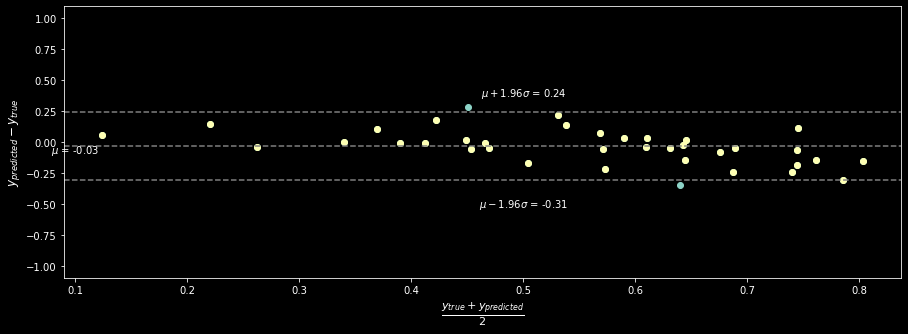

In [18]:
d,din = bland_altman_plot(results_ls_aug,per_change)


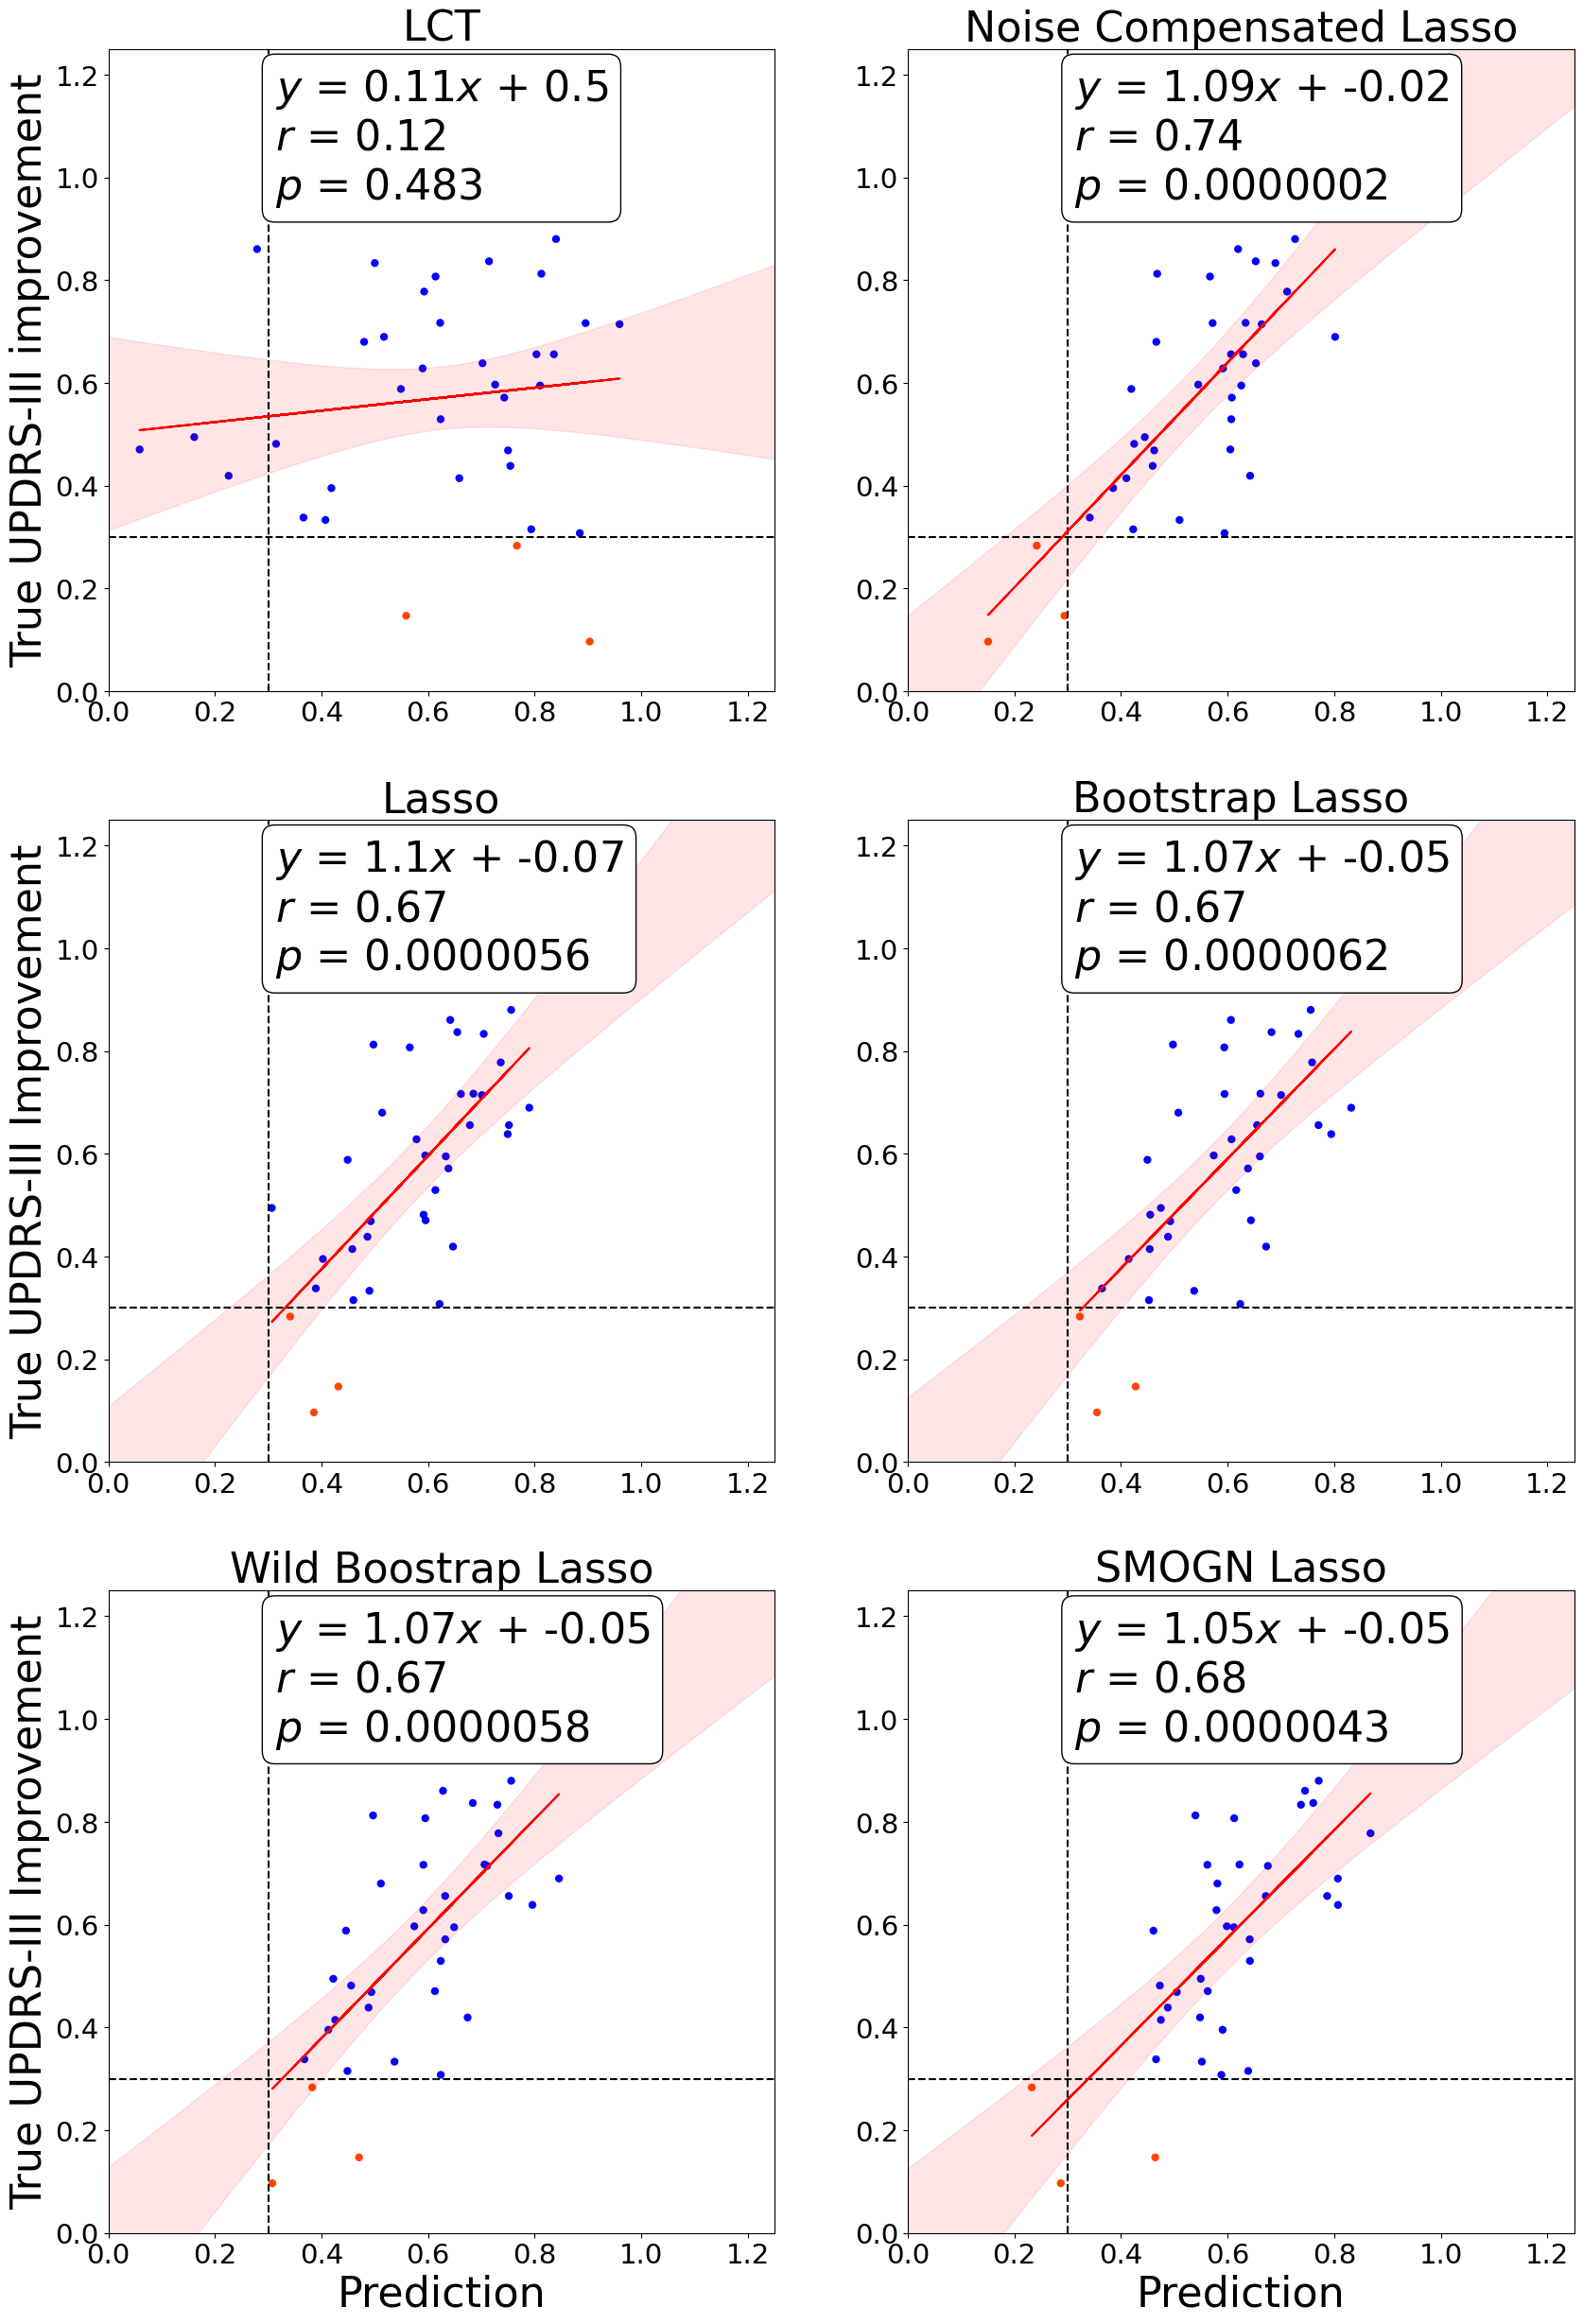

In [33]:
ylim = 1.25
fs = 32
ofx = 0.25
ofy = 0.75
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 30]
fig,ax = plt.subplots(3,2,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0,0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0,0].plot(pre_imp,y_model,color='r')
ax[0,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))  
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,ylim)
ax[0,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].set_title('LCT',fontsize=fs)
ax[0,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[1,1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1,1].plot(results_ls,y_model,color='r')
ax[1,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls,per_change,ylim)
ax[1,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].set_title('Bootstrap Lasso',fontsize=fs)
ax[1,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[2,1].scatter(results_ls_smogn,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_smogn),per_change)
y_model = results_ls_smogn*lr.slope+lr.intercept
ax[2,1].plot(results_ls_smogn,y_model,color='r')
ax[2,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[2,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls_smogn,per_change,ylim)
ax[2,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[2,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,1].set_xlabel('Prediction',fontsize=fs)
ax[2,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,1].set_title('SMOGN Lasso',fontsize=fs)

ax[2,0].scatter(results_ls_wbs,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_wbs),per_change)
y_model = results_ls_wbs*lr.slope+lr.intercept
ax[2,0].plot(results_ls_wbs,y_model,color='r')
ax[2,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[2,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls_wbs,per_change,ylim)
ax[2,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[2,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,0].set_xlabel('Prediction',fontsize=fs)
ax[2,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,0].set_ylabel('True UPDRS-III Improvement',fontsize=fs)
ax[2,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,0].set_title('Wild Boostrap Lasso',fontsize=fs)

ax[0,1].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[0,1].plot(results_ls_aug,y_model,color='r')
ax[0,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls_aug,per_change,ylim)
ax[0,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].set_title('Noise Compensated Lasso',fontsize=fs)
plt.ylim([0,ylim])
plt.xlim([0,ylim])

ax[1,0].scatter(results_lsw,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_lsw),per_change)
y_model = results_lsw*lr.slope+lr.intercept
ax[1,0].plot(results_lsw,y_model,color='r')
ax[1,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_lsw,per_change,ylim)
ax[1,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].set_title('Lasso',fontsize=fs)
ax[1,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_ylabel('True UPDRS-III Improvement',fontsize=fs)
ax[1,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)


plt.savefig('plots_auto.png')
plt.style.use('default')

In [20]:
K_nz_wbs

[array(['original_shape_MinorAxisLength Right substantia nigra',
        'original_gldm_LargeDependenceHighGrayLevelEmphasis Right substantia nigra',
        'original_glrlm_ShortRunLowGrayLevelEmphasis Right substantia nigra',
        'square_glrlm_RunLengthNonUniformity Right substantia nigra',
        'wavelet-LHL_firstorder_Kurtosis Right substantia nigra',
        'wavelet-LHL_glcm_Correlation Right substantia nigra',
        'wavelet-HHL_firstorder_Skewness Right substantia nigra',
        'wavelet-HHL_glcm_ClusterShade Right substantia nigra',
        'wavelet-HHL_glcm_Correlation Right substantia nigra',
        'lbp-3D-k_glszm_HighGrayLevelZoneEmphasis Right subthalamic nucleus',
        'wavelet-LLH_gldm_DependenceVariance Right subthalamic nucleus',
        'wavelet-LLH_gldm_SmallDependenceHighGrayLevelEmphasis Right subthalamic nucleus',
        'wavelet-LHL_firstorder_Energy Right subthalamic nucleus',
        'wavelet-HLL_glcm_Idn Right subthalamic nucleus',
        'wave

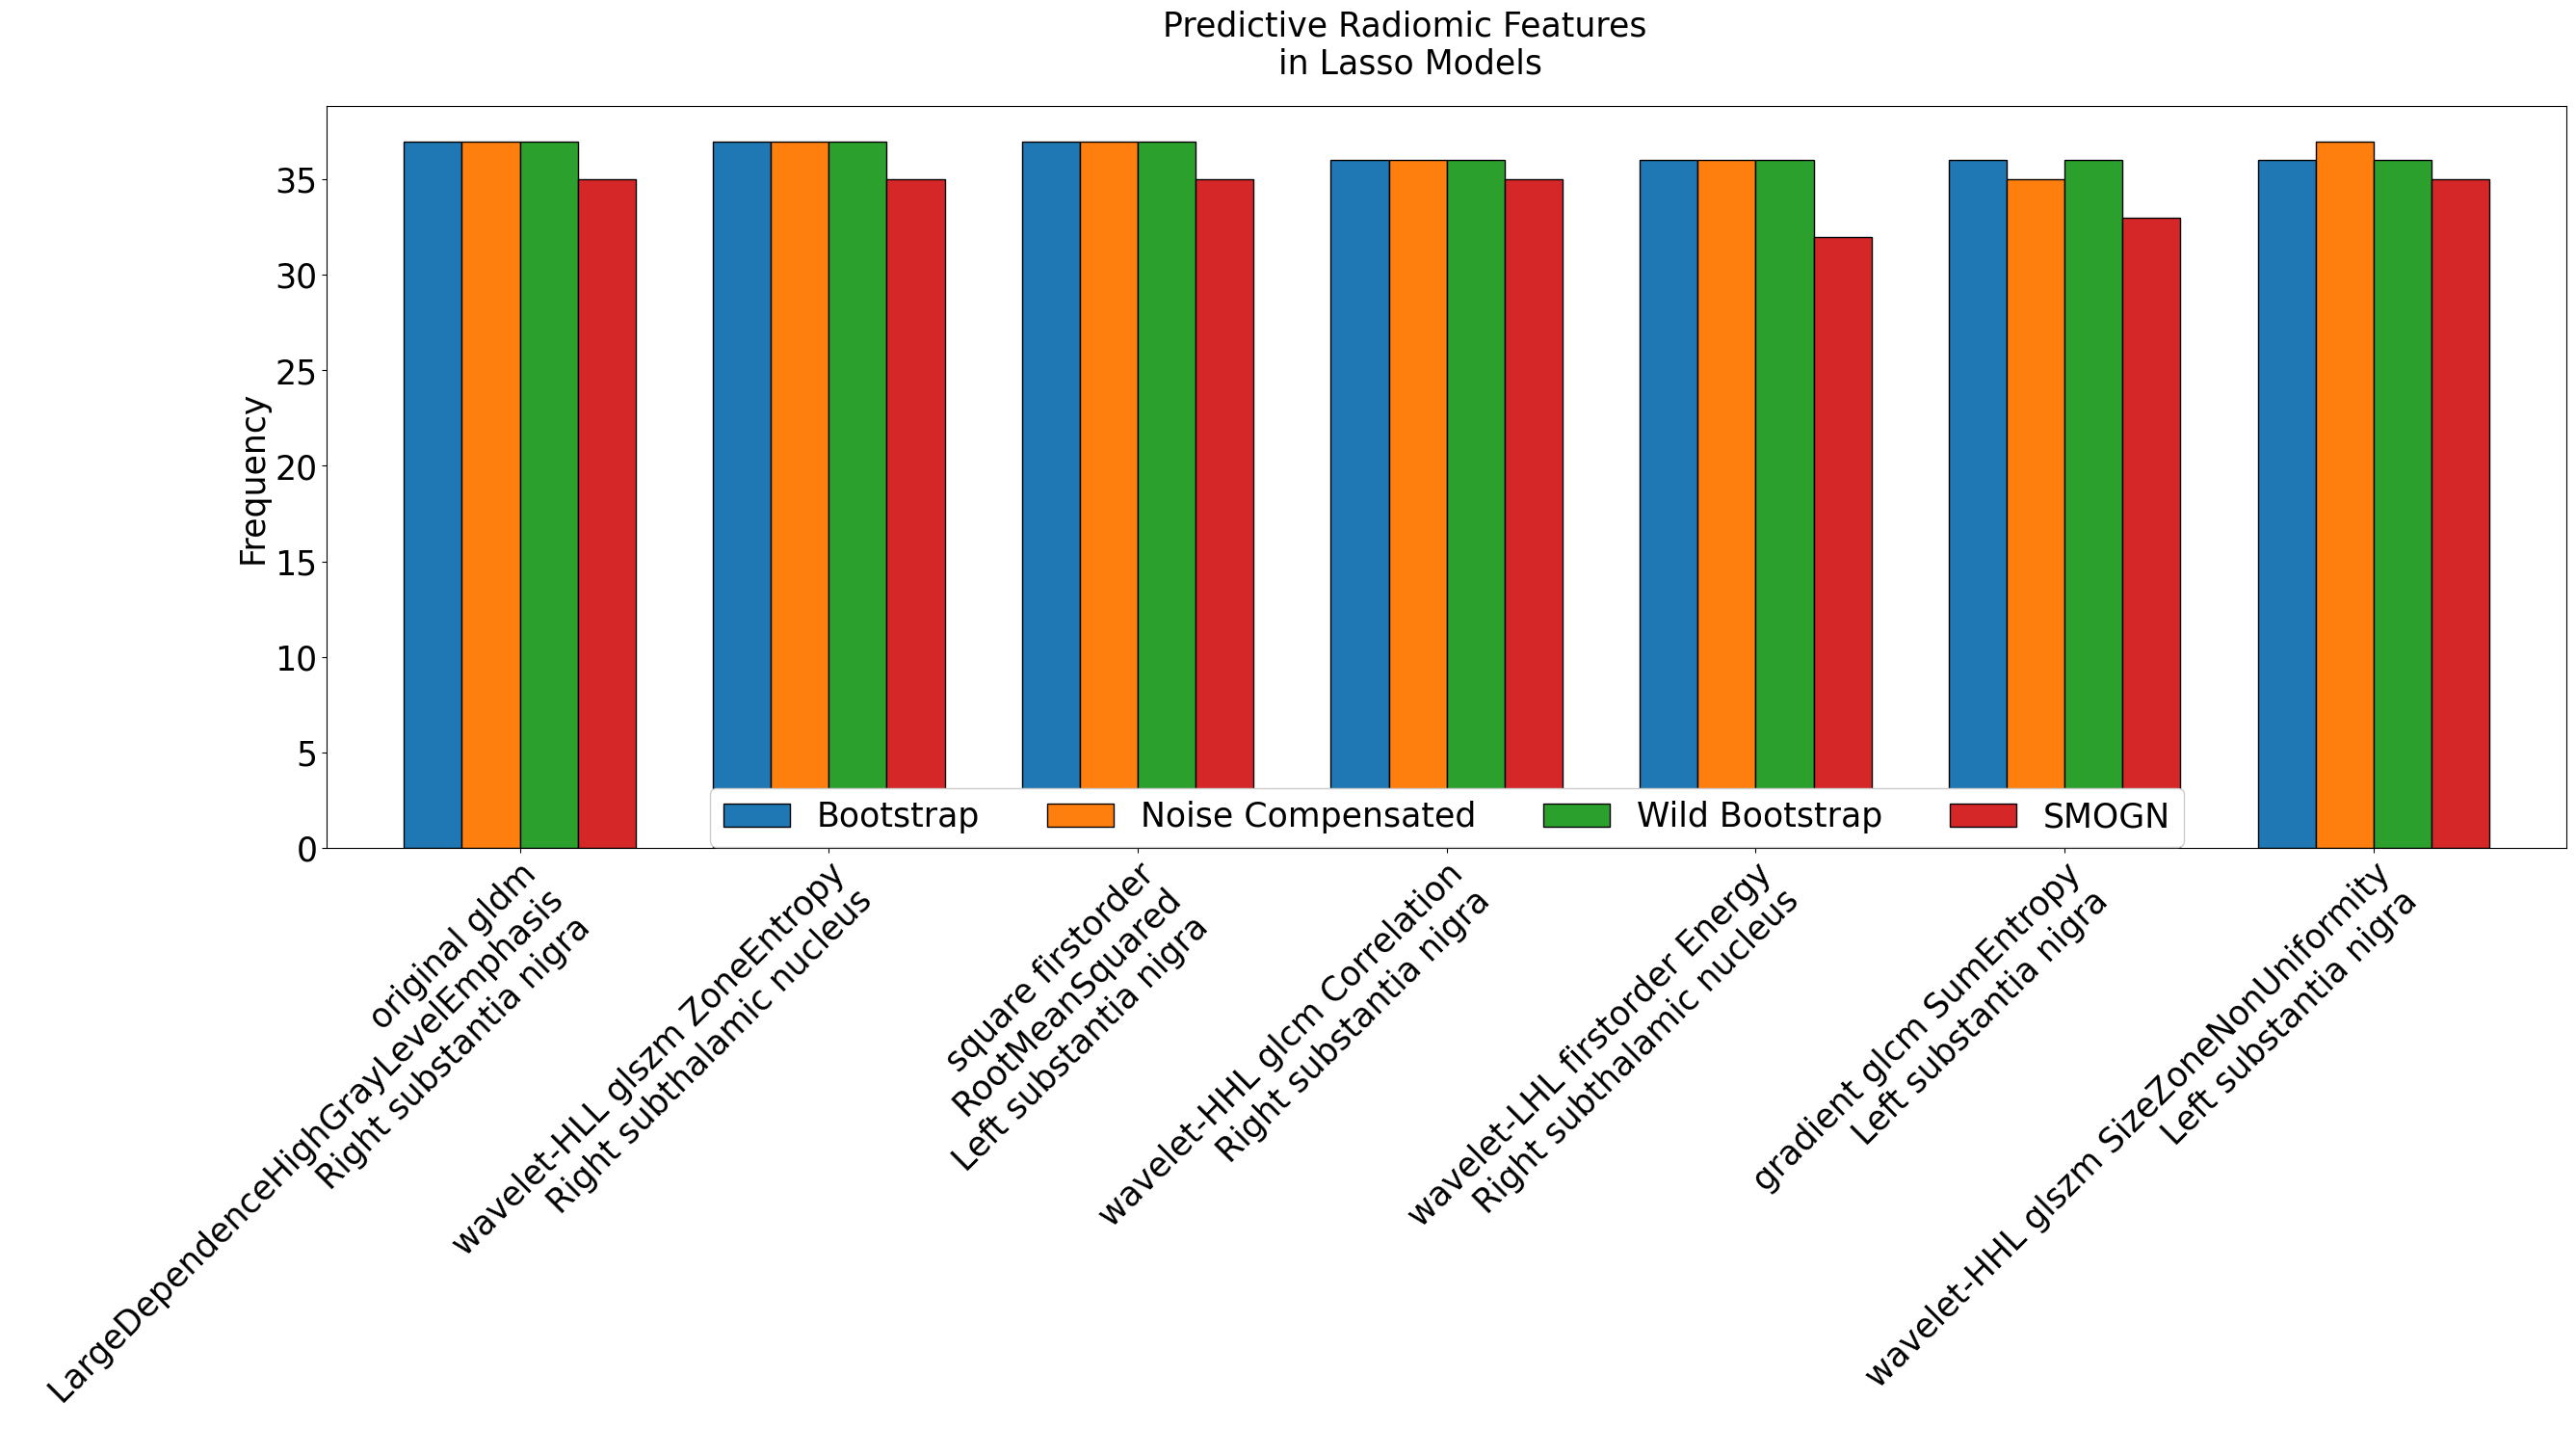

In [21]:
from collections import Counter

E_nz_nc = np.load('beta_nz_nc_cvs.npy',allow_pickle=True)
plt.rcParams["figure.figsize"] = (30,10)
fig, axes = plt.subplots(1,1,sharey=True)

R = [item for sublist in K_nz_nc for item in sublist]
letter_counts = Counter(R)
lc = {x: count for x, count in letter_counts.items() if count >= 35}
df_lc = pd.DataFrame.from_dict(lc, orient='index')
df_lc.sort_values(0, ascending=False, inplace=True)

R = [item for sublist in K_nz_vl for item in sublist]
letter_counts = Counter(R)
lcv = {x: count for x, count in letter_counts.items() if x in lc.keys()}
df_lcv = pd.DataFrame.from_dict(lcv, orient='index')
df_lcv.sort_values(0, ascending=False, inplace=True)

R = [item for sublist in K_nz_wbs for item in sublist]
letter_counts = Counter(R)
lwbs = {x: count for x, count in letter_counts.items() if x in lc.keys()}
df_lwbs = pd.DataFrame.from_dict(lwbs, orient='index')
df_lwbs.sort_values(0, ascending=False, inplace=True)

R = [item for sublist in K_nz_smogn for item in sublist]
letter_counts = Counter(R)
lsm = {x: count for x, count in letter_counts.items() if x in lc.keys()}
df_lsm = pd.DataFrame.from_dict(lsm, orient='index')
df_lsm.sort_values(0, ascending=False, inplace=True) 

df = pd.concat([df_lc, df_lcv, df_lwbs, df_lsm],axis=1)
df.columns = ["Bootstrap","Noise Compensated", "Wild Bootstrap", "SMOGN"]
df.index = df.index.str.replace('_', ' ')
df.index = df.index.str.replace(' L', '\n L')
df.index = df.index.str.replace(' R', '\n R')
df.plot(ax=axes, kind='bar', legend=True, fontsize=fs//1.25, width=0.75, edgecolor='black')

plt.legend(loc='lower center', framealpha=1,fontsize=fs//1.25, ncol=4, bbox_to_anchor=(0.5, -0.02175))
plt.xticks(rotation=45,ha='right',wrap=True)
plt.suptitle('Predictive Radiomic Features \nin Lasso Models',fontsize=fs//1.25)
plt.ylabel('Frequency',fontsize=fs//1.25)

plt.style.use('default')
plt.savefig('feats_auto.png')

In [22]:
beta = np.zeros((len(per_change),len(lc.keys())))
X_r =  np.zeros((3,len(lc.keys())))
X_nr =  np.zeros((3,len(lc.keys())))
for j in np.arange(0,len(K_nz_nc)):
    c = 0
    for k in np.arange(0,len(K_nz_nc[j])):
        if K_nz_nc[j][k] in lc.keys():
            beta[j,c] = E_nz_nc[j][k]
    
            X_r[:,c] = (X_all_c.reshape(len(per_change),-1)[per_change>0.85,np.where(K_all_c == K_nz_nc[j][k])]).astype(float)
            X_nr[:,c] = (X_all_c.reshape(len(per_change),-1)[per_change<0.3,np.where(K_all_c == K_nz_nc[j][k])]).astype(float)

            c = c+1

for i in np.arange(len(lc.keys())):
    res = stats.wilcoxon(X_r[:,i].ravel(),X_nr[:,i].ravel())
    if res.pvalue <= 0.05:
        print(res.statistic, res.pvalue)     
        print('Responder median:',np.median(X_r[:,i]/np.amax(X_r[:,i])),'and non-responder median',np.median(X_nr[:,i]/np.amax(X_nr[:,i])))  

beta_r = (beta[per_change>0.85,:])
beta_nr = (beta[per_change<0.3,:])
res = stats.wilcoxon(beta_r.ravel(),beta_nr.ravel())

In [23]:
from sklearn.metrics import precision_recall_curve, recall_score, accuracy_score, precision_score

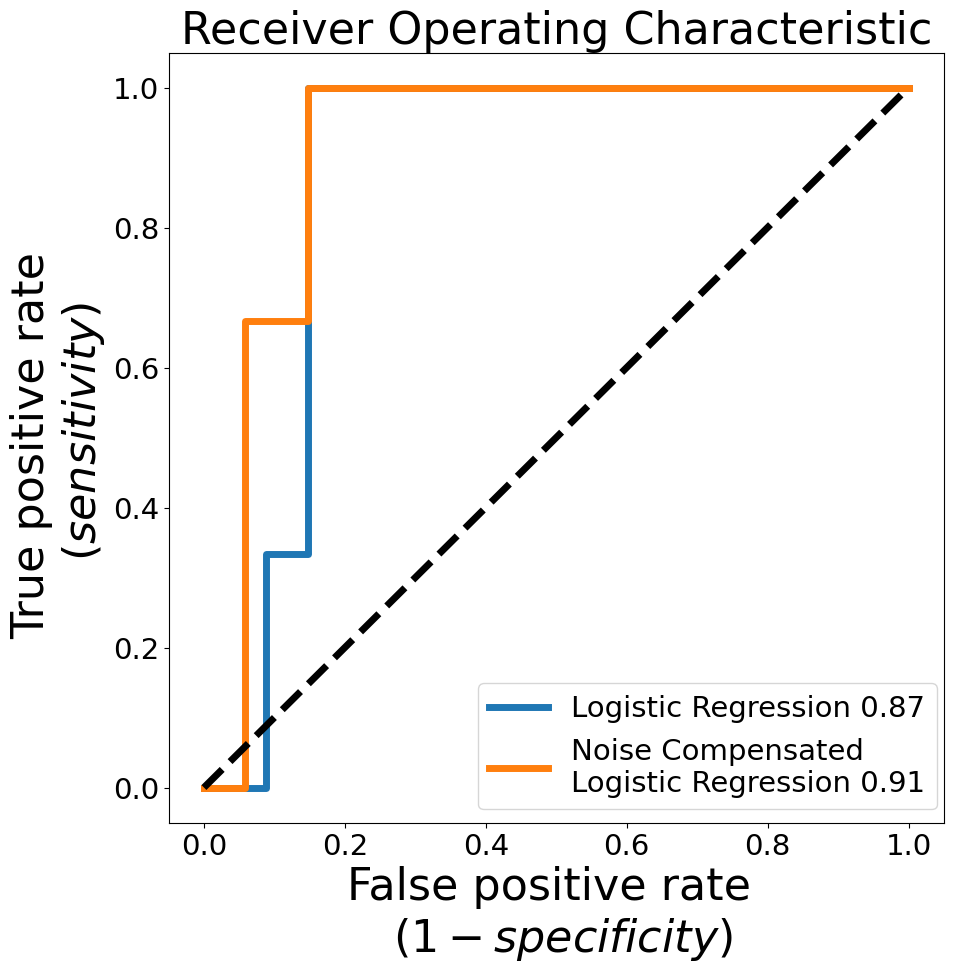

In [31]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
t = 0.3
y_bin = per_change<t

y_predicted_ls = results_ls < 0.3
y_predicted_ls_aug = results_ls_aug < 0.3
y_predicted_lct = pre_imp < 0.3
y_predicted_aug = 1-results_lgrp_aug
y_predicted_lr = 1-results_lgrp
y_predicted_smogn = results_ls_smogn < 0.3
y_predicted_wbs = results_ls_wbs < 0.3

estimators = np.vstack((lct_change < 0.3,results_lgr,results_lgr_aug,results_ls < 0.3,results_ls_aug < 0.3,results_ls_smogn < 0.3,results_ls_wbs < 0.3))


fprlsa, tprlsa, _ = roc_curve(y_bin,  y_predicted_ls_aug)
fprls, tprls, _ = roc_curve(y_bin,  y_predicted_ls)
fprl, tprl, _ = roc_curve(y_bin,  y_predicted_lct)
fpra, tpra, ts_aug = roc_curve(y_bin, y_predicted_aug)
fprlr, tprlr, ts = roc_curve(y_bin, y_predicted_lr)
pra,rca,ta = precision_recall_curve(y_bin,y_predicted_aug)
prlr,rclr,tlr = precision_recall_curve(y_bin,y_predicted_lr)

scores = np.zeros((7,4))

for j in np.arange(estimators.shape[0]):
    spf = recall_score(y_bin,estimators[j,:],pos_label=0)
    scores[j,0] = spf
    sns = recall_score(y_bin,estimators[j,:])
    scores[j,1] = sns
    acc = accuracy_score(y_bin,estimators[j,:])
    scores[j,2] = acc
    prec = precision_score(y_bin,estimators[j,:])
    scores[j,3] = prec

fprlss, tprlss, _ = roc_curve(y_bin, y_predicted_smogn)
fprlwb, tprlwb, _ = roc_curve(y_bin, y_predicted_wbs)
roc_auc_lr = auc(fprlr, tprlr)
roc_auc_lr_aug = auc(fpra, tpra)
roc_auc_ls = auc(fprls, tprls)
roc_auc_lct = auc(fprl, tprl)
roc_auc_ls_aug = auc(fprlsa, tprlsa)
roc_auc_ls_smogn = auc(fprlss, tprlss)
roc_auc_ls_wbs = auc(fprlwb, tprlwb)

ax.plot(fprlr, tprlr, label = 'Logistic Regression %0.2f' % roc_auc_lr, linewidth=5)
ax.plot(fpra, tpra, label = 'Noise Compensated \nLogistic Regression %0.2f' % roc_auc_lr_aug, linewidth=5)

ax.plot(np.linspace(0,1,len(fpra)),np.linspace(0,1,len(fpra)),linewidth=5,color='black',linestyle='dashed')
ax.set_title('Receiver Operating Characteristic',fontsize=fs)
ax.set_xlabel('False positive rate \n $(1-specificity$)',fontsize=fs)
ax.set_ylabel('True positive rate \n $(sensitivity$)',fontsize=fs)
ax.xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.legend(bbox_to_anchor=(0.38,0.2),fontsize=fs//1.5)

plt.style.use('default')
plt.show()

In [25]:
def rec(res,pc):
        y_true = pc
        y_pred = res
        epsilon_0 = 0.0
        epsilon_max = 1.0
        d_epsilon = 0.01
        y = []
        x = np.arange(epsilon_0,epsilon_max,d_epsilon)
        epsilon = np.abs(y_true-y_pred) 
        for j in np.arange(len(x)):
            c = 0
            for k in np.arange(len(epsilon)):
                if epsilon[k] < x[j]:
                    c = c+1
            y.append(c/len(y_true))
        auc_rec = scipy.integrate.simps(y,x)/epsilon_max
        return x, np.array(y), auc_rec



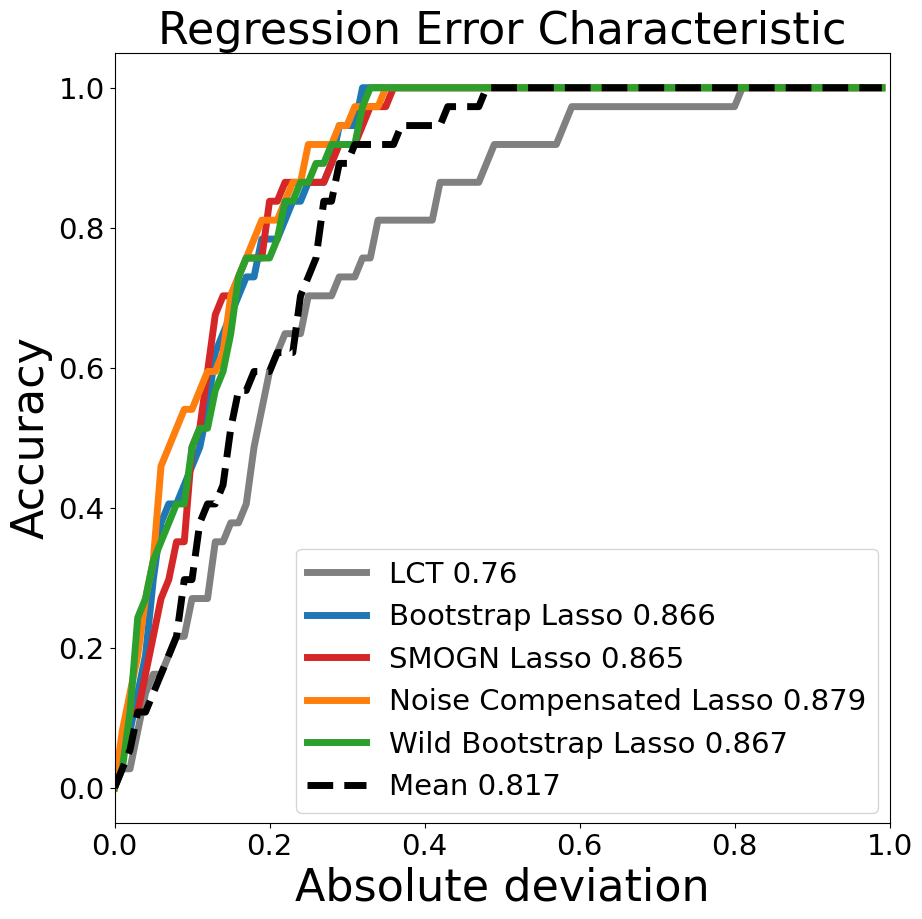

In [26]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
x_lct,y_lct,eta = rec(pre_imp,per_change)
plt.plot(x_lct,y_lct,linewidth=5,label='LCT %0.2f' % eta, color='gray')
# x_ls,y_ls,a,eta = rec(results_ls,per_change)
# plt.plot(x_ls,y_ls,label='Lasso %0.2f' % eta)
x_ls,y_ls,eta = rec(results_lsw,per_change)
plt.plot(x_ls,y_ls,linewidth=5,label='Bootstrap Lasso %0.3f' % eta, color='tab:blue')
x_smogn,y_smogn,eta = rec(results_ls_smogn,per_change)
plt.plot(x_smogn,y_smogn,linewidth=5,label='SMOGN Lasso %0.3f' % eta, color='tab:red')
x_lsa,y_lsa,eta = rec(results_ls_aug,per_change)
plt.plot(x_lsa,y_lsa,linewidth=5,label='Noise Compensated Lasso %0.3f' % eta, color='tab:orange')
x_wbs,y_wbs,eta = rec(results_ls_wbs,per_change)
plt.plot(x_wbs,y_wbs,linewidth=5,label='Wild Bootstrap Lasso %0.3f' % eta, color="tab:green")
x_n,y_n,eta = rec(np.mean(per_change)*np.ones_like(per_change),per_change)
plt.plot(x_n,y_n,linestyle='dashed',color='k',linewidth=5,label='Mean %0.3f' % eta)
plt.xlabel('Absolute deviation',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.xlim([0,1])
plt.title('Regression Error Characteristic',fontsize=fs)
ax.xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.legend(bbox_to_anchor=(0.215,0.375),fontsize=fs//1.5)


.

(-3.0, 3.0)

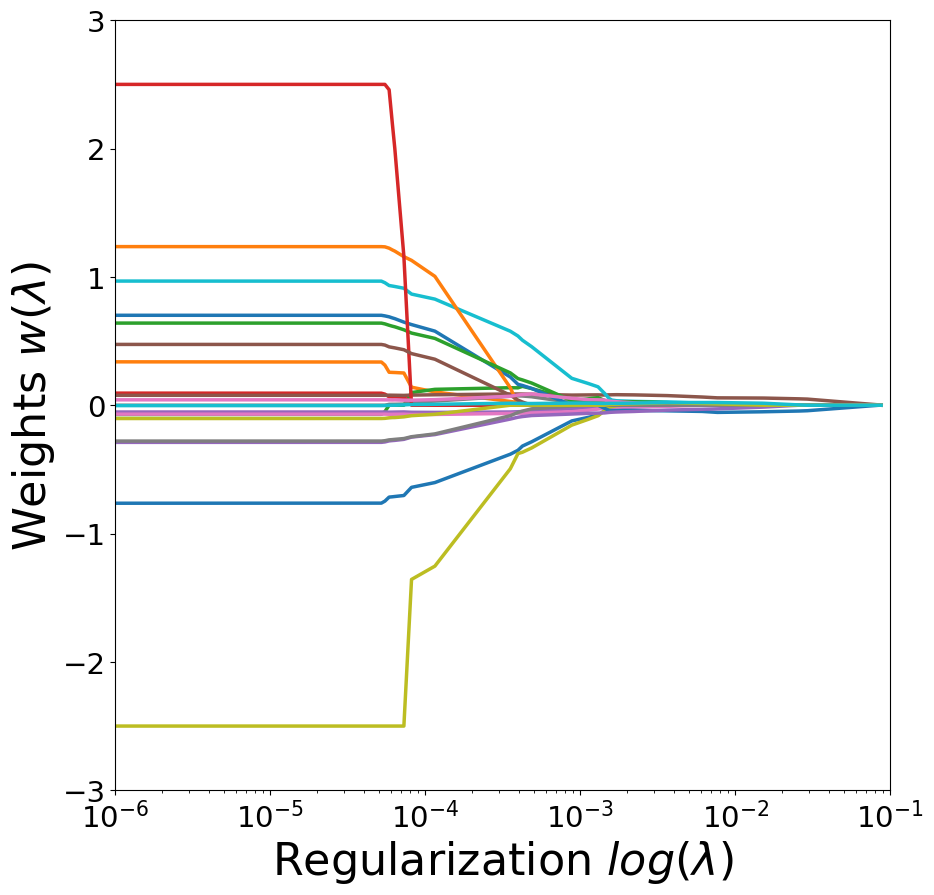

In [27]:
alphas_lasso, _, coefs_lasso = slm.lars_path(X0_ss0[:,0:20], y_train, method="lasso", verbose=True)
from itertools import cycle
plt.rcParams["figure.figsize"] = (10,10)
plt.figure(1)
coefs_lasso[coefs_lasso > 2.5] = 2.5
coefs_lasso[coefs_lasso < -2.5] = -2.5
for coef_l in zip(coefs_lasso):
    l1 = plt.semilogx(alphas_lasso, np.squeeze(coef_l),linewidth=2.5)
plt.xticks(fontsize=fs//1.5)
plt.yticks(fontsize=fs//1.5)

plt.xlabel(r"Regularization $log(\lambda)$",fontsize=fs)
plt.ylabel(r"Weights $w(\lambda)$",fontsize=fs)
plt.axis("tight")
plt.style.use('default')
plt.xlim([1e-6,0.1])
plt.ylim([-3,3])